In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import utils

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt

import cv2
from numpy import asarray

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# en la carpeta tat_txt deben guardarse todos los .txt que se vayan a procesar
# deben ser los unicos .txt en esta carpeta

dic_fot = {}
for carpeta in ['./bebe', './gato', './pajaro', './perro', './rostro' ]:
    dirs = os.walk( carpeta )
            
    contenido = [file for file in dirs]
    archivos = [x for x in contenido[0][2] if '.png' in x or '.jpg' in x]
    borrar = [x for x in contenido[0][2] if not '.png' in x and not '.jpg' in x]
    
    dic_fot[carpeta] = [archivos, borrar]

In [ ]:
for carpeta in dic_fot.keys():
    print(f' { carpeta }: fotos: { len(dic_fot[carpeta][0]) }, borra: { len(dic_fot[carpeta][1]) }  ')


In [ ]:
# prueba

image = cv2.imread('./bebe/' + dic_fot['./bebe'][0][img])
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))

cv2.imshow('image', image) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
dataset = []
i = 0

for carpeta in dic_fot.keys():
    print(carpeta)
    for pic in dic_fot[carpeta][0]:
        print(carpeta+'/' + pic)
        
        image = cv2.imread(carpeta+'/' + pic)
        image = cv2.resize(image, (128, 128))
        dataset.append([asarray(image), i, carpeta[2:]])
        #print(type(data))
    i += 1

In [ ]:
np.random.shuffle(dataset)

np.save("mydata.npy", dataset)



In [4]:
dataset = np.load("mydata.npy", allow_pickle=True)

In [5]:
# convert the data and labels to NumPy arrays
data   = np.array([data[0] for data in dataset])
labels = np.array([data[1] for data in dataset])


# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
# respaldo
n_train = int(len(dataset) * .75)

trainX = data[0:n_train]
testX  = data[n_train:]

trainY = labels[0:n_train]
testY  = labels[n_train:]

In [49]:
etiquetas = []
for x in lb.classes_:
    result = np.where(dataset[:,1] == x)[0][0]
    etiquetas.append(dataset[result, 2])

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i][0], cmap=plt.cm.binary)
    plt.xlabel(data_train[i][2])
plt.show()

In [124]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [76]:
# load VGG16, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())


[INFO] summary for base model...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

In [111]:
# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [125]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=25)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
29/29 [==============================] - 394s 14s/step - loss: 1.9403 - acc: 0.1397 - val_loss: 1.6036 - val_acc: 0.2326
Epoch 2/25
29/29 [==============================] - 448s 15s/step - loss: 1.6026 - acc: 0.2738 - val_loss: 1.3758 - val_acc: 0.5139
Epoch 3/25
29/29 [==============================] - 522s 18s/step - loss: 1.4686 - acc: 0.4013 - val_loss: 1.2879 - val_acc: 0.5069
Epoch 4/25
29/29 [==============================] - 496s 17s/step - loss: 1.3971 - acc: 0.4623 - val_loss: 1.2298 - val_acc: 0.5139
Epoch 5/25
29/29 [==============================] - 445s 15s/step - loss: 1.3508 - acc: 0.4545 - val_loss: 1.1792 - val_acc: 0.5833
Epoch 6/25
29/29 [==============================] - 520s 18s/step - loss: 1.3366 - acc: 0.4734 - val_loss: 1.1308 - val_acc: 0.6215
Epoch 7/25
29/29 [==============================] - 563s 19s/step - loss: 1.2865 - acc: 0.4967 - val_loss: 1.0874 - val_acc: 0.6632
Epoch 8/25
29/29 [========

No handles with labels found to put in legend.


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


<Figure size 432x288 with 0 Axes>

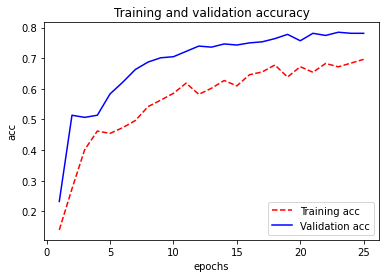

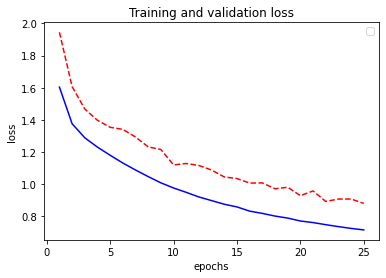

<Figure size 432x288 with 0 Axes>

In [129]:
history_dict = H.history
print(history_dict.keys())

#dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

acc      = H.history[     'acc' ]
val_acc  = H.history[ 'val_acc' ]
loss     = H.history[    'loss' ]
val_loss = H.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [152]:
# Guardar el Modelo
model.save('path_to_my_model.h5')

## Conclusion: para deep learning, entrenar modelo con GPU

In [163]:
# Recrea exactamente el mismo modelo solo desde el archivo
model = keras.models.load_model('my_google_model.h5')

In [164]:
y_pred = model.predict(testX)
y_pred = np.around(y_pred)

predY = [np.argmax(ye) for ye in y_pred]
obsY  = [np.argmax(ye) for ye in testY]

con_mat = confusion_matrix(obsY, predY)
con_mat = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)



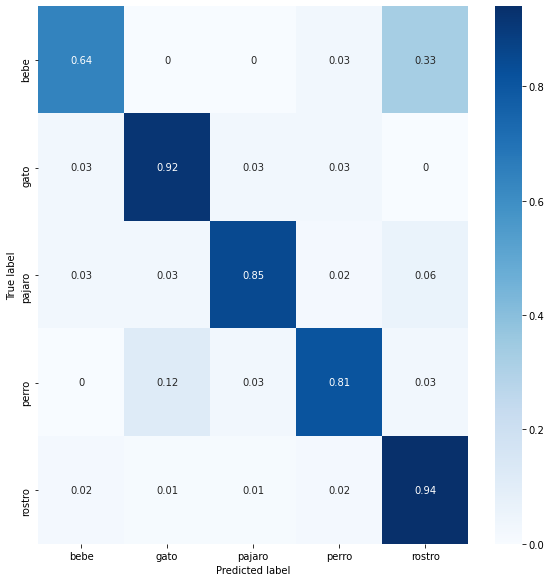

In [165]:
import pandas as pd
import seaborn as sns
con_mat_df = pd.DataFrame(con_mat, index = etiquetas, columns = etiquetas)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [180]:
# probando el modelo
# carga de datos de prueba

dirs = os.walk( './imgs_recon' )
            
contenido = [file for file in dirs]
archivos = [x for x in contenido[0][2] if '.png' in x or '.jpg' in x]

datos = []

for pic in archivos:
    image = cv2.imread('./imgs_recon'+'/' + pic)
    image = cv2.resize(image, (128, 128))
    datos.append([asarray(image), pic])
    

In [181]:
fotos   = np.array([dato[0] for dato in datos])

r_pred = model.predict(fotos)
r_pred = np.around(r_pred)

predV = [np.argmax(ye) for ye in r_pred]

resultado = {}

i = 0
for dato in datos:
    tmp = dato[1][:-4]
    resultado[tmp] = etiquetas[predV[i]]
    i += 1

In [182]:
resultado

{'ave': 'pajaro',
 'bebe': 'bebe',
 'beto': 'rostro',
 'Cocky': 'perro',
 'gato': 'gato',
 'Rejuve': 'rostro'}

In [151]:
datos = []
i = 0
for pic in archivos:
    datos.append([pic, fotos[i]])
    i += 1
    
datos = np.array(datos)
np.save("myprueba.npy", datos)

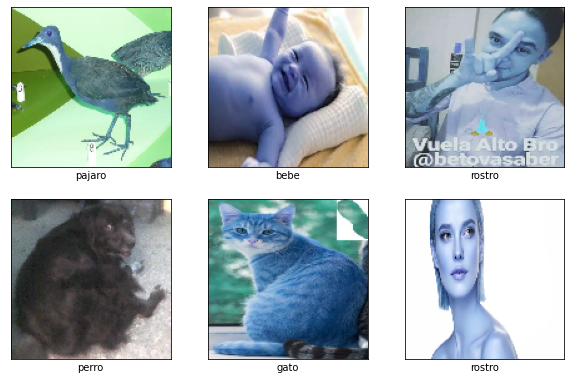

In [187]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fotos[i], cmap=plt.cm.binary)
    plt.xlabel(etiquetas[predV[i]])
plt.show()